In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lbg_forecast import emulator as em
from lbg_forecast import population_model as pop

In [2]:
bands = ["u","g","r","i","z","y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

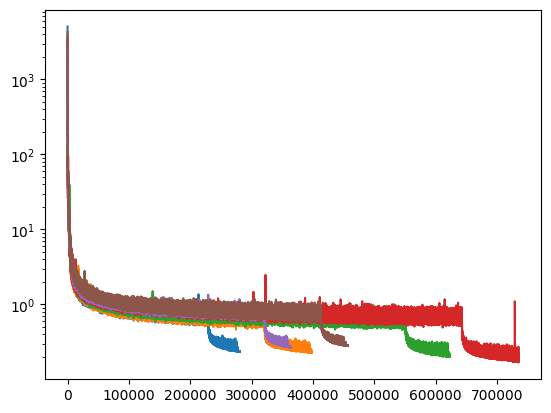

In [3]:
for x in loss_bands:
    plt.plot(x)

plt.yscale("log")

0.23611518740653992
0.22993335127830505
0.20380619168281555
0.21476612985134125
0.27032792568206787
0.2810138761997223


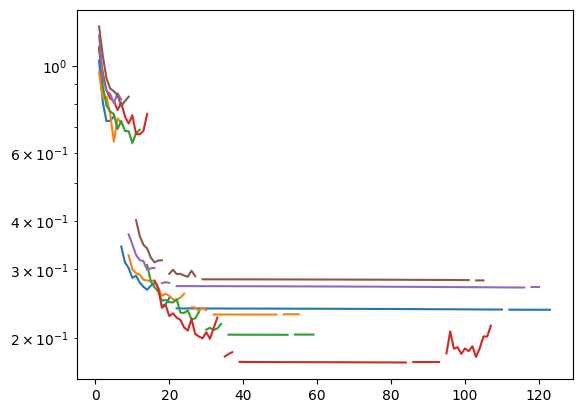

In [4]:
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [6]:
sps_params_train = np.load("training_data/sps_parameters_51000000.npy")
phot_train = np.load("training_data/photometry_51000000.npy")
phot_train[:10, :]

array([[29.75678959, 28.12467694, 24.70015701, 22.82596194, 22.39992023,
        22.23689741],
       [50.        , 50.        , 50.        , 50.        , 50.        ,
        50.        ],
       [43.74367257, 44.68674064, 39.50330438, 37.20680209, 35.99343678,
        35.31727539],
       [50.        , 50.        , 50.        , 50.        , 50.        ,
        50.        ],
       [50.        , 50.        , 50.        , 50.        , 50.        ,
        50.        ],
       [50.        , 50.        , 50.        , 50.        , 50.        ,
        50.        ],
       [48.35166802, 50.        , 48.37299673, 43.23567461, 40.85205201,
        39.27746556],
       [45.01657123, 47.07453335, 46.50290717, 40.36182139, 37.5986772 ,
        35.86547279],
       [50.        , 50.        , 50.        , 50.        , 50.        ,
        50.        ],
       [50.        , 50.        , 50.        , 50.        , 50.        ,
        50.        ]])

Text(0, 0.5, '$\\Delta m$')

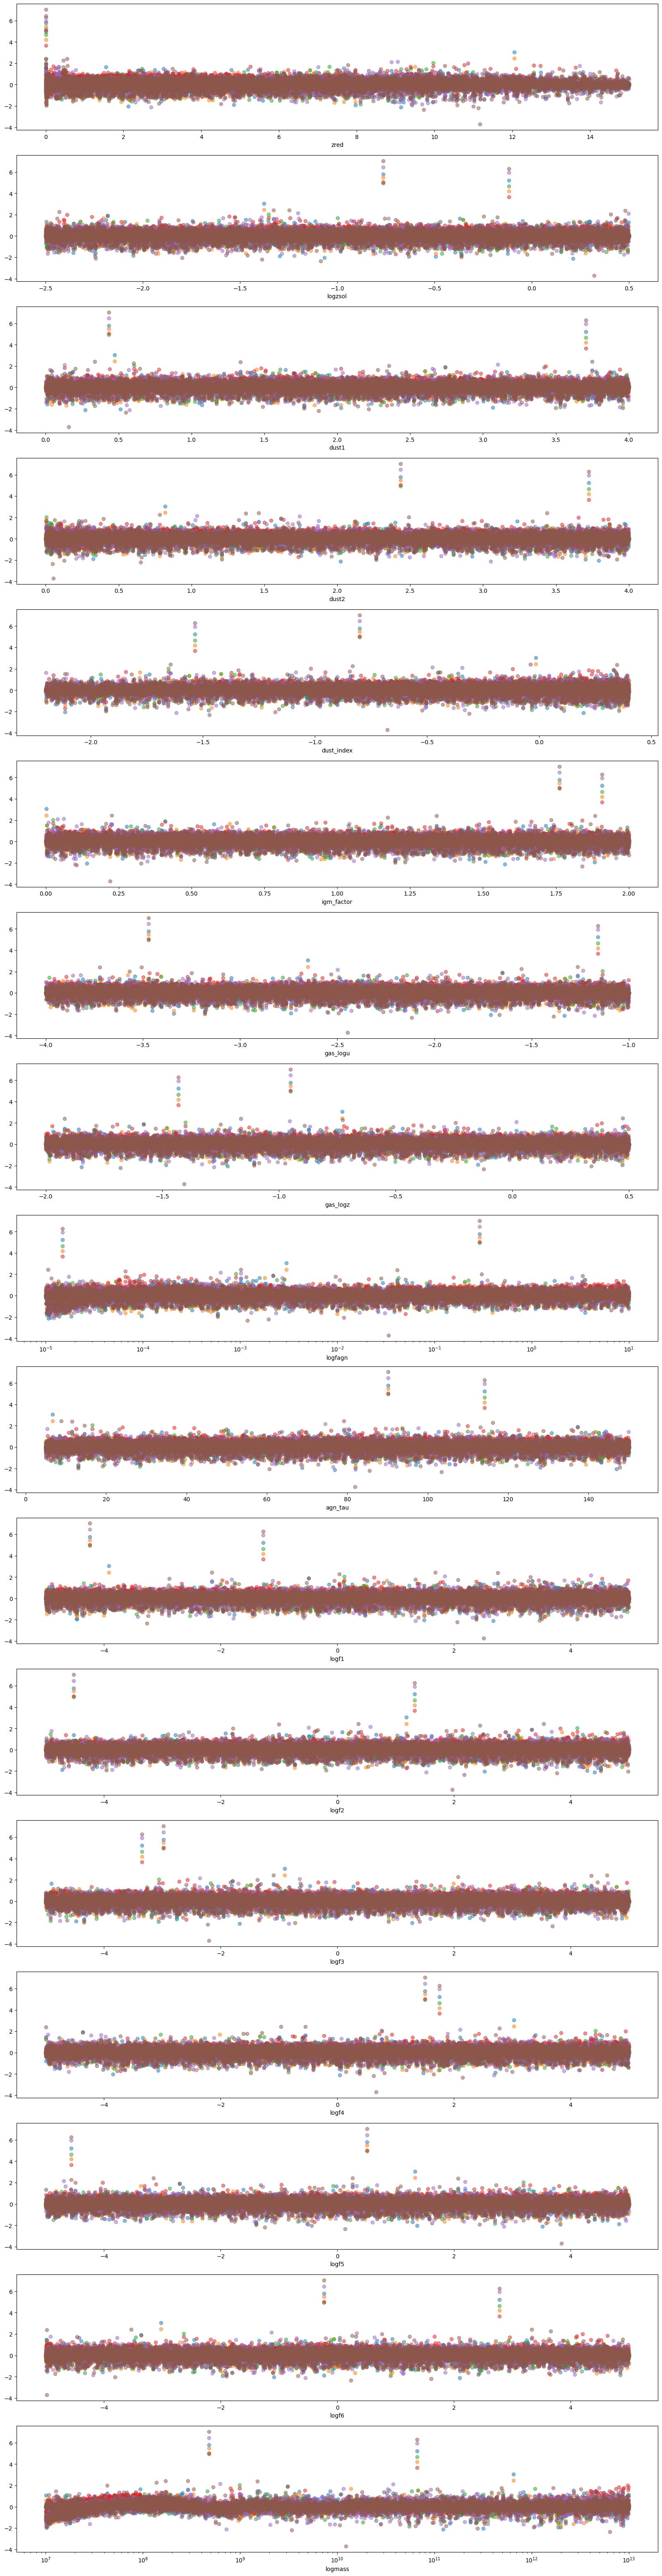

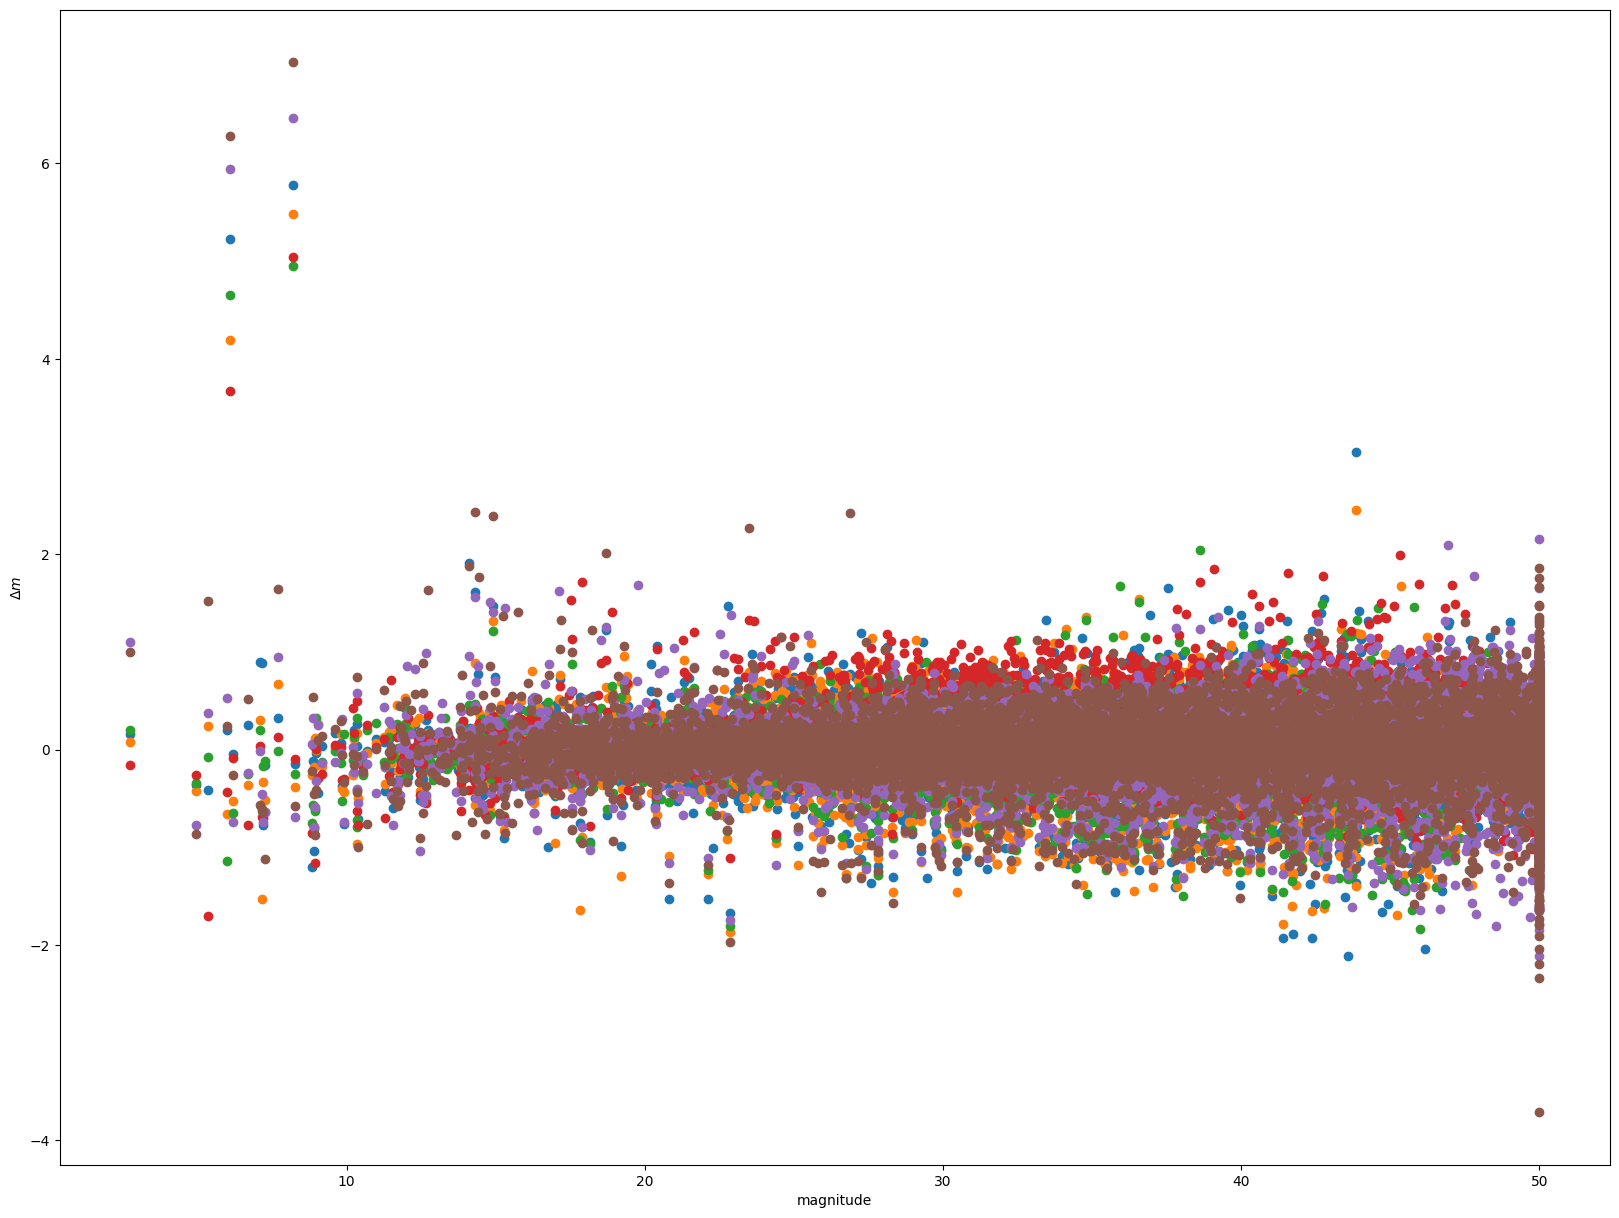

In [7]:
nsamples=20000
band = 3
sps_params = sps_params_train[:nsamples, :]
m_true = phot_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params_train[:nsamples,:])

dm = np.hsplit(m_mimic-m_true, 6)

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    axes[i].scatter(sps_params[:, i], dm[0], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[1], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[2], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[3], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[4], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[5], alpha=alpha)
    axes[i].set_xlabel(pop.sps_parameter_names()[i])
    if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
        axes[i].set_xscale('log')


fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)


axes2.scatter(m_true[:, band], dm[0])
axes2.scatter(m_true[:, band], dm[1])
axes2.scatter(m_true[:, band], dm[2])
axes2.scatter(m_true[:, band], dm[3])
axes2.scatter(m_true[:, band], dm[4])
axes2.scatter(m_true[:, band], dm[5])
axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')


In [8]:
len(np.where(phot_train[:, 5] > 40)[0])/len(phot_train[:, 0])

0.5878970980392156

In [11]:
np.std(dm[0])

0.23709837859709387